## Variational Autoencoders

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv1D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv1DTranspose, UpSampling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

### Data prep

In [21]:
# Import data
X_all = np.loadtxt('Datasets/X_all_diagnostics.csv') 
Y_all = pd.read_csv('Datasets/Y_all_diagnostics.csv') 
classes=['NORM', 'CD', 'HYP', 'STTC', 'MI']
Y_all = Y_all[classes]

In [135]:
def norm(x):
    return (x-min(x))/(max(x)-min(x))

for i in range(X_all.shape[0]):
    X_all[i,:] = norm(X_all[i,:])

In [136]:
index=np.arange(X_all.shape[0])
np.random.shuffle(index)
X = X_all[index]
# Y = Y_all[index]
x_train=X[:10000]
x_test=X[10000:12000]

In [162]:
def show_history(history):
    print(history.history.keys())

    plt.subplot(1, 1, 1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')    
        
    plt.subplot(1, 2, 2)
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Basic autoencoders

In [160]:
# 1 layer encoder/ 1 layer decoder
def create_AutoEncoder():
    
    input_image = Input(shape=(200,))
    
    encoded = Dense(32, activation = 'relu')(input_image)
    
    decoded = Dense(200,activation = 'sigmoid')(encoded)
    
    encoder = Model(inputs = input_image, outputs = encoded)
    
    auto_encoder = Model(inputs = input_image, outputs = decoded)
    
    return auto_encoder, encoder

(auto_encoder, encoder) = create_AutoEncoder()

print("\n############### ENCODER #################")
encoder.summary()
print("\n############### ENCODER + DECODER #################")
auto_encoder.summary()


############### ENCODER #################
Model: "model_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
dense_148 (Dense)            (None, 32)                6432      
Total params: 6,432
Trainable params: 6,432
Non-trainable params: 0
_________________________________________________________________

############### ENCODER + DECODER #################
Model: "model_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
dense_148 (Dense)            (None, 32)                6432      
_________________________________________________________________
dense_

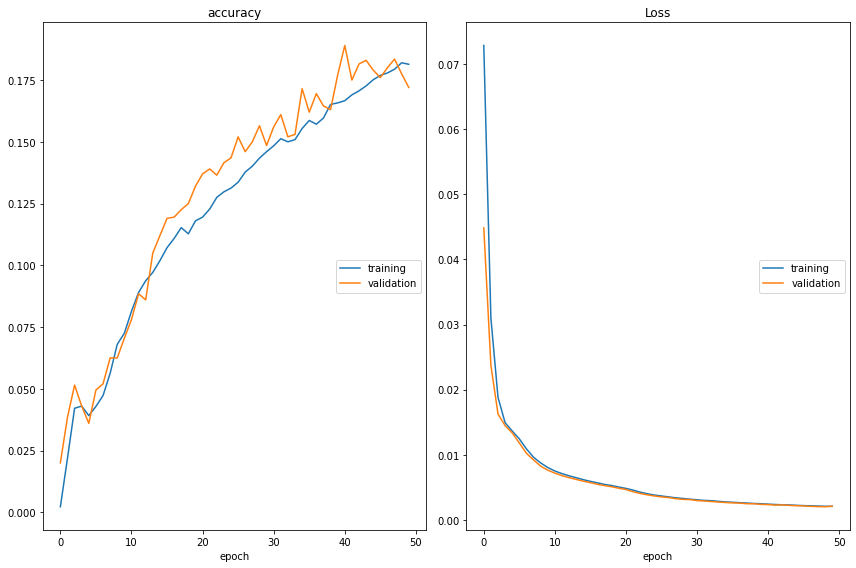

accuracy
	training         	 (min:    0.002, max:    0.182, cur:    0.181)
	validation       	 (min:    0.020, max:    0.189, cur:    0.172)
Loss
	training         	 (min:    0.002, max:    0.073, cur:    0.002)
	validation       	 (min:    0.002, max:    0.045, cur:    0.002)


In [161]:
# !pip install livelossplot
from livelossplot import PlotLossesKeras
(auto_encoder, encoder) = create_AutoEncoder()
auto_encoder.compile(optimizer="adam", loss = "mse", metrics = ["accuracy"])
history = auto_encoder.fit(x_train, x_train, epochs = 50, shuffle = True, batch_size = 200, validation_split = 0.2, callbacks = [PlotLossesKeras()])




Original ECG - first 10 of X_test


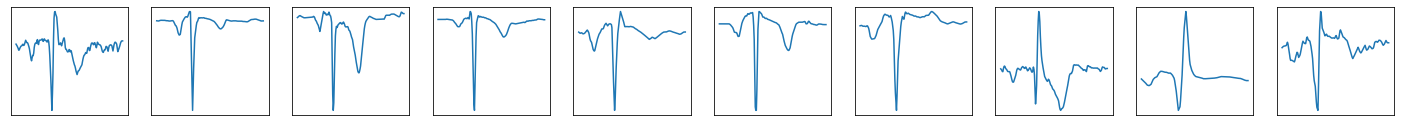

Encoded ECG - first 10 of X_test


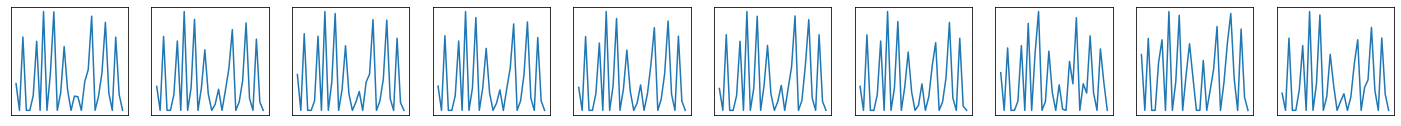

Decoded ECG - first 10 of X_test


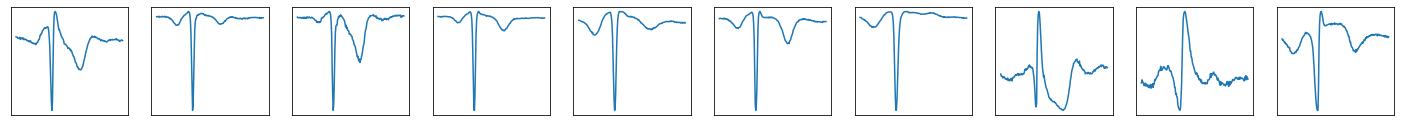

In [163]:
def visualize_predictions(encoder,autoencoder, X_test):
     
    encoded_images = encoder.predict(X_test)
    predicted_images = autoencoder.predict(X_test)
    
    # Original Images
    print("Original ECG - first 10 of X_test")
    plt.figure(figsize=(50, 2))
    for i in range(10):
        plt.grid()
        ax = plt.subplot(1, 20, i + 1)
        plt.plot(X_test[i,:])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    # display Encoded Images (latent space)
    print("Encoded ECG - first 10 of X_test")
    plt.figure(figsize=(50, 2))
    for i in range(10):
        ax = plt.subplot(1, 20, i + 1)
#         plt.imshow(encoded_images[i].reshape(8,4))
        plt.plot(encoded_images[i,:])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
        
    # display Decoded Images
    print("Decoded ECG - first 10 of X_test")
    plt.figure(figsize=(50, 2))
    for i in range(10):
        ax = plt.subplot(1, 20, i+ 1)
        plt.plot(predicted_images[i,:])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
        
visualize_predictions(encoder,auto_encoder,x_test)

### CNN - AE

In [ ]:
from tensorflow.keras import backend as K
def create_AutoEncoder_CNN():
    
    input_image = Input(shape=(200,1,))
    encoded = Conv1D(32, 16, padding='same', activation='relu')(input_image)
    encoded = Conv1D(64, 16, padding='same', activation='relu')(encoded)
    shape=K.int_shape(encoded)
    encoded = Flatten()(encoded)
    latent = Dense(100, activation='relu')(encoded)

    
    decoded = Dense(shape[1]*shape[2])(latent)
    decoded = Reshape((shape[1],shape[2]))(decoded)
    decoded = Conv1DTranspose(16, 8, padding='same', activation='relu', strides=1)(decoded)
    decoded = Conv1DTranspose(16, 8, padding='same', activation='relu', strides=1)(decoded)
    output = Conv1DTranspose(1, 8, padding='same', activation='sigmoid', strides=1)(decoded)
#     output = Conv1D(8, 1, padding='same', activation='sigmoid', strides=1)(decoded)
#
    
    
    encoder = Model(inputs = input_image, outputs = latent)
    
    auto_encoder = Model(inputs = input_image, outputs = output)
    
    return auto_encoder, encoder

(auto_encoder, encoder) = create_AutoEncoder_CNN()

print("\n############### ENCODER #################")
encoder.summary()
print("\n############### ENCODER + DECODER #################")
auto_encoder.summary()

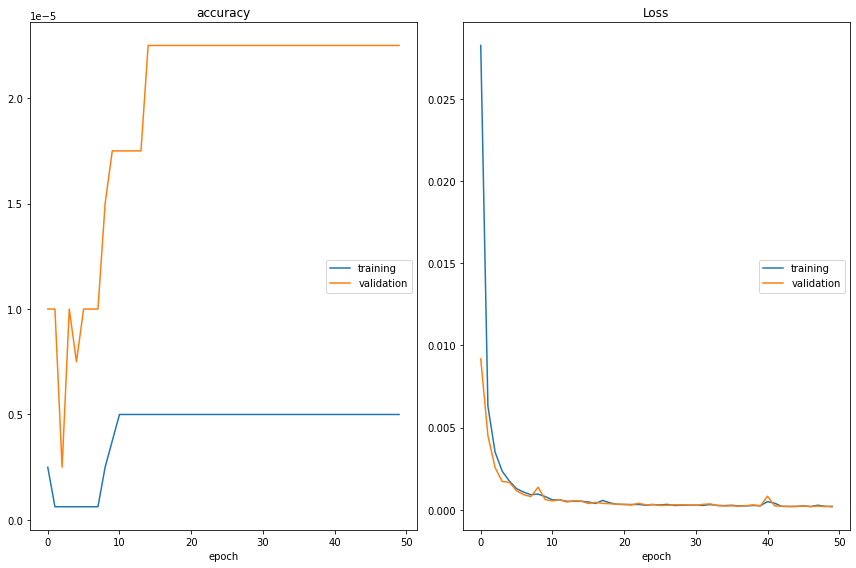

accuracy
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.000, max:    0.028, cur:    0.000)
	validation       	 (min:    0.000, max:    0.009, cur:    0.000)


In [128]:
(auto_encoder, encoder) = create_AutoEncoder_CNN()
auto_encoder.compile(optimizer="adam", loss = "mse", metrics = ["accuracy"])
history = auto_encoder.fit(x_train, x_train, epochs = 50, shuffle = True, batch_size = 200, validation_split = 0.2, callbacks = [PlotLossesKeras()])



Original ECG - first 10 of X_test


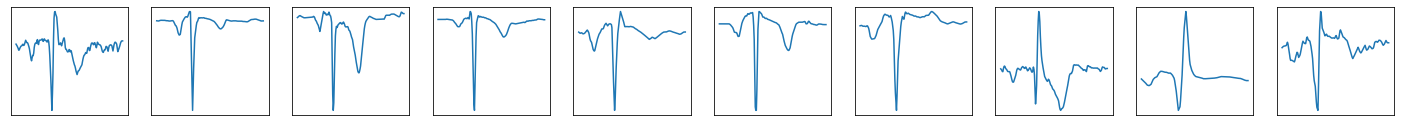

Encoded ECG - first 10 of X_test


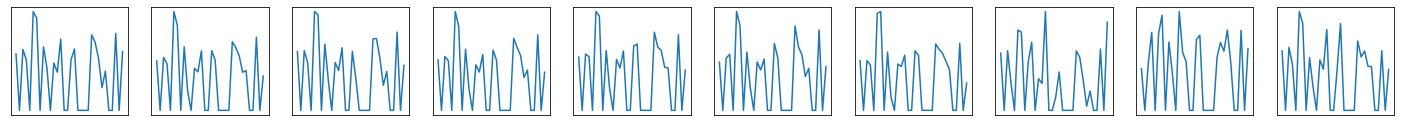

Decoded ECG - first 10 of X_test


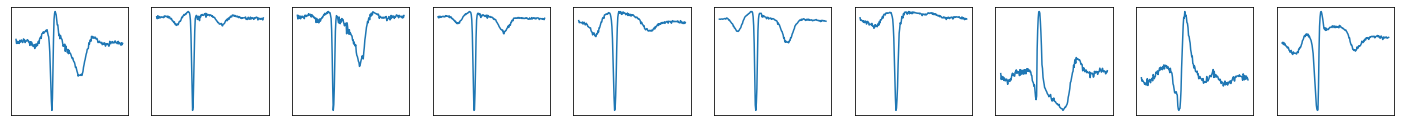

In [152]:
visualize_predictions(encoder,auto_encoder,x_test)

### Denoising

In [193]:
noise = np.random.normal(loc=0, scale=0.1, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0, scale=0.1, size=x_test.shape)
x_test_noisy = x_test + noise

# adding noise may exceed normalized pixel values>1.0 or <0.0
# clip pixel values >1.0 to 1.0 and <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


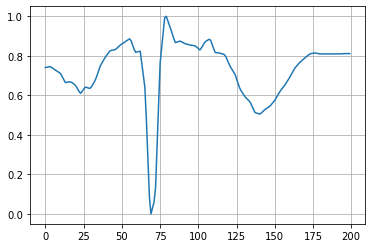

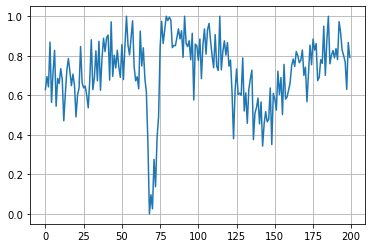

In [194]:
# Example of ECG before/after addition of noise
plt.plot(x_train[0])
plt.grid()
plt.show()

plt.plot(x_train_noisy[0])
plt.grid()
plt.show()

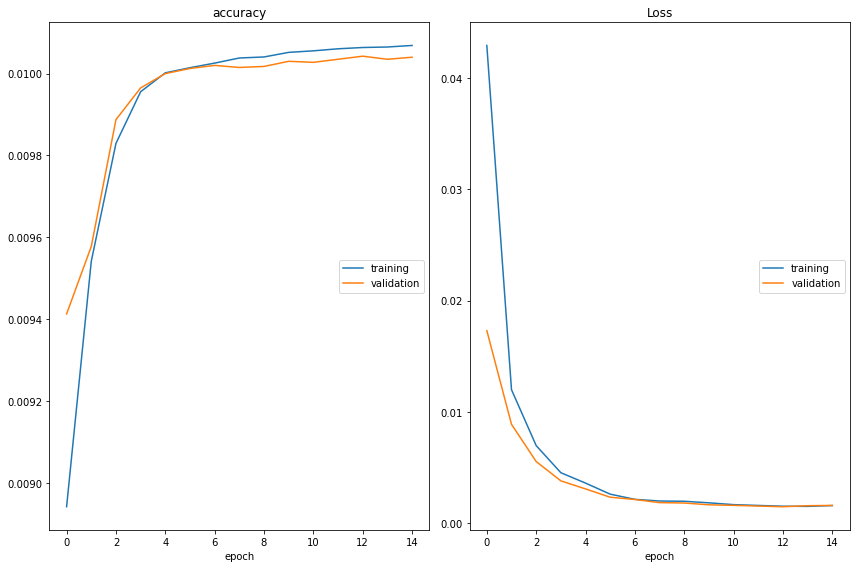

accuracy
	training         	 (min:    0.009, max:    0.010, cur:    0.010)
	validation       	 (min:    0.009, max:    0.010, cur:    0.010)
Loss
	training         	 (min:    0.002, max:    0.043, cur:    0.002)
	validation       	 (min:    0.001, max:    0.017, cur:    0.002)


In [195]:
(auto_encoder, encoder) = create_AutoEncoder_CNN()
auto_encoder.compile(optimizer="adam", loss = "mse", metrics = ["accuracy"])
history = auto_encoder.fit(x_train_noisy, x_train, epochs = 15, shuffle = True, batch_size = 200, validation_split = 0.2, callbacks = [PlotLossesKeras()])


In [196]:
j=50
x_decoded = auto_encoder.predict(x_test_noisy[j:j+10])

Noisy


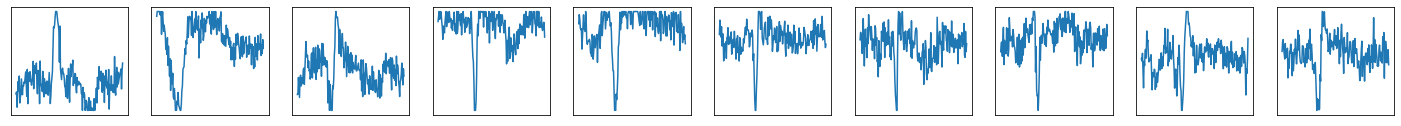

Denoised


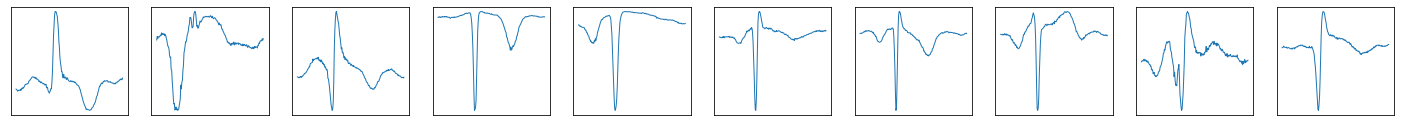

Original


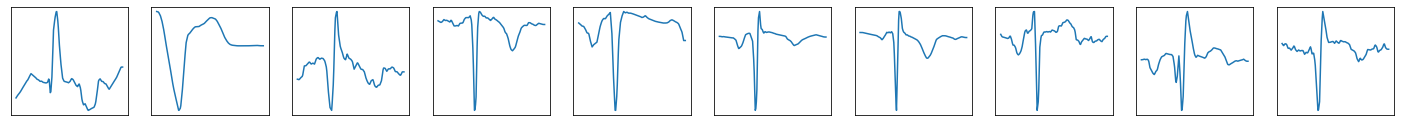

In [214]:
print("Noisy")
plt.figure(figsize=(50, 2))
for i in range(10):
    plt.grid()
    ax = plt.subplot(1, 20, i + 1)
    plt.plot(x_test_noisy[i+j,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# display Encoded Images (latent space)
print("Denoised")
plt.figure(figsize=(50, 2))
for i in range(10):
    ax = plt.subplot(1, 20, i + 1)
#         plt.imshow(encoded_images[i].reshape(8,4))
    plt.plot(x_decoded[i,:], lw=1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Original")
plt.figure(figsize=(50, 2))
for i in range(10):
    ax = plt.subplot(1, 20, i + 1)
#         plt.imshow(encoded_images[i].reshape(8,4))
    plt.plot(x_test[i+j, :])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [210]:
label_pred=[0.01, 0.02, 0.7]